In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
#We read the datafile of TOI-2431.
df_raw = pd.read_csv('../../data/rvdata/TIC 258804746_rv_bin_new.csv')

#We also add another column called "tel" to these DataFrames.
#This describes the instrument that was used to obtain these data.
df_raw['tel'] = ['MERCATOR' for i in range(len(df_raw))]

#We only take "bjd", "rv", "e_rv" and "tel" columns from the df_all as follows. (We basically remove other columns)
df = df_raw[['bjd','rv','e_rv','tel']]

#Then we define those columns as "time", "mnvel", "errvel" and "tel" as follows.
df.columns = ['time','mnvel','errvel','tel']

df

,time,mnvel,errvel,tel
0,2.460662e+06,-12.671987,2.791394,MERCATOR
1,2.460662e+06,-26.541499,3.369376,MERCATOR
2,2.460664e+06,-7.491304,2.515655,MERCATOR
3,2.460665e+06,1.525364,1.955555,MERCATOR
4,2.460666e+06,6.579270,1.909009,MERCATOR
5,2.460681e+06,-22.931295,4.563359,MERCATOR
6,2.460681e+06,-2.342805,3.011773,MERCATOR
7,2.460686e+06,-2.671890,6.264056,MERCATOR


In [8]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/utils.py'>)

In [9]:
#We get the Prior File for the target we are analyzing as follows.
#Please open one of the .txt files to see how to setup the Prior Files.
f = '../../data/priors/TOI2431_PriorsNewRV.txt'
reload(gaiafitwithtransit)

#We get the time, radial velocity and error of radial velocities for the first instrument/dataset.
t = df_raw.bjd.values
rv = df_raw.rv.values
e_rv = df_raw.e_rv.values

#We then use "LPFunctionRVOnly" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunctionRVOnly(t,rv,e_rv,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.GaiaFitRVOnly(L)

Reading in priorfile from ../../data/priors/TOI2431_PriorsNewRV.txt
  prior          arg1          arg2        label  description priortype  fixed
0    NP  2.241958e-01  5.480000e-08         P_p1         P_p1     model  False
1    NP  2.460259e+06  1.573097e-04        tp_p1        tp_p1     model  False
2    FP  0.000000e+00  0.000000e+00       ecc_p1       ecc_p1     model   True
3    FP  9.000000e+01  9.000000e+01     omega_p1     omega_p1     model   True
4    UP  0.000000e+00  5.000000e+01         K_p1         K_p1     model  False
5    UP -5.000000e+02  5.000000e+02        gamma        gamma     model  False
6    UP  0.000000e+00  1.000000e+02     sigma_rv     sigma_rv     model  False
7    FP  0.000000e+00  0.000000e+00     gammadot     gammadot     model   True
8    FP  0.000000e+00  0.000000e+00  gammadotdot  gammadotdot     model   True


In [10]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
#Try increasing de_iter to 2000, it is global optimizer and it wont change MCMC. It will distribute the walkers better,
#but the initial optimization will be longer than that. Right now for quick runs this is fine.
#50000 Steps would probably be optimal.
TF.minimize_PyDE(de_iter=200,mc_iter=4000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0      P_p1  2.241958e-01  2.241955e-01  2.241961e-01  2.241958e-01  1.247703e-09
1     tp_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06  4.023779e-06
2      K_p1  2.500000e+01  0.000000e+00  5.000000e+01  4.498832e+00  2.050117e+01
3     gamma  0.000000e+00 -5.000000e+02  5.000000e+02 -8.137228e+00  8.137228e+00
4  sigma_rv  5.000000e+01  0.000000e+00  1.000000e+02  9.806335e+00  4.019367e+01
LogPost value: -21.73400819513726
LnL value: -29.947466052658065
Log priors 8.213457857520805
Running MCMC
MCMC iterations= 4000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106

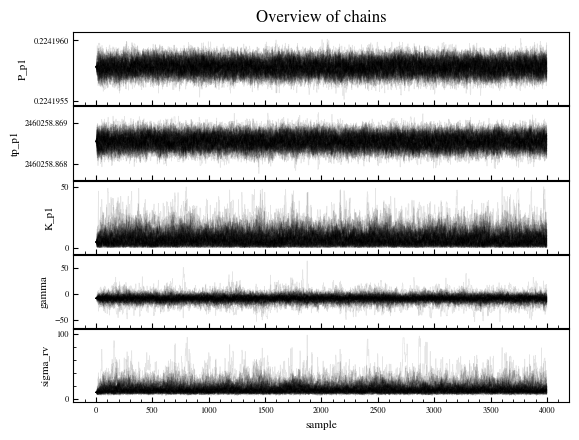

In [11]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

#plt.savefig("chains.png", dpi = 500)
plt.show();

In [12]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

,P_p1,tp_p1,K_p1,gamma,sigma_rv
0,0.224196,2.460259e+06,6.197481,-11.814286,13.890422
1,0.224196,2.460259e+06,6.197481,-11.814286,13.890422
2,0.224196,2.460259e+06,5.857661,-12.453168,16.153844
3,0.224196,2.460259e+06,5.777782,-12.527567,16.224255
4,0.224196,2.460259e+06,5.777782,-12.527567,16.224255
...,...,...,...,...,...
299995,0.224196,2.460259e+06,6.637409,-15.920252,16.479871
299996,0.224196,2.460259e+06,6.637409,-15.920252,16.479871
299997,0.224196,2.460259e+06,4.713371,-13.112129,13.592349
299998,0.224196,2.460259e+06,5.910682,-11.824515,13.809779


In [13]:
# Method #1. Checking the GR statistic.
# We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR STATISTICS")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
mcmc_help.plot_chains(chains_after_burnin,labels=TF.lpf.ps_vary.labels)
print(50 * "-")

GR STATISTICS
--------------------------------------------------
[1.00810618 1.00702233 1.00997088 1.01003744 1.01431771]
--------------------------------------------------


In [14]:
# Method #2. Checking autocorrelation time.
# Checking if at least 50 uncorrelated samples
# Calculate autocorrelation time
# print(50 * "-")
# print("Autocorrelation Time")
# print(50 * "-")
# tau = TF.sampler.get_autocorr_time()
# (NSTEPS/tau)/50  # this should be larger than 1 in all cases
# print(50 * "-")

In [15]:
#We calculate the Planet Mass using the posteriors K, Mstar, P and Eccentricity.
#Instead of Mstar note that we sample from the reported ExoFOP radius.
df_post['mp'] = utils.msini_from_rvs(df_post["K_p1"].values,
                                     np.random.normal(0.6400000,0.0846982,flatchain.shape[0]),
                                     df_post["P_p1"].values,
                                     e=0,
                                     i=90)
df_post["mp"]

0         0.013779
1         0.013019
2         0.013720
3         0.013592
4         0.012520
            ...   
299995    0.016244
299996    0.016691
299997    0.010028
299998    0.014439
299999    0.014868
Name: mp, Length: 300000, dtype: float64

In [16]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
print(df_medvals[['Labels','values']])

     Labels                                    values
0      P_p1  $0.22419578_{-0.00000005}^{+0.00000005}$
0     tp_p1     $2460258.86856_{-0.00016}^{+0.00016}$
0      K_p1                       $6.2_{-3.9}^{+5.4}$
0     gamma                      $-8.4_{-5.0}^{+4.8}$
0  sigma_rv                      $13.1_{-3.5}^{+6.0}$


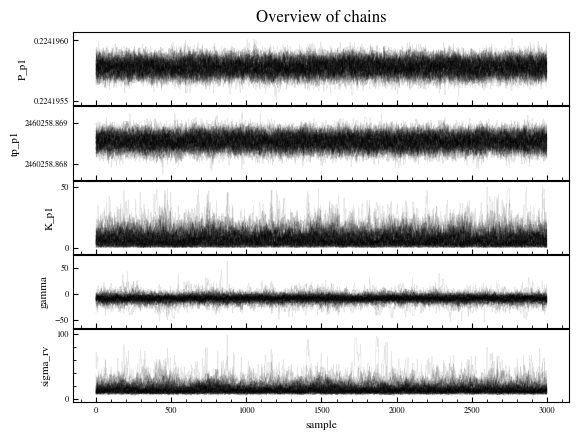

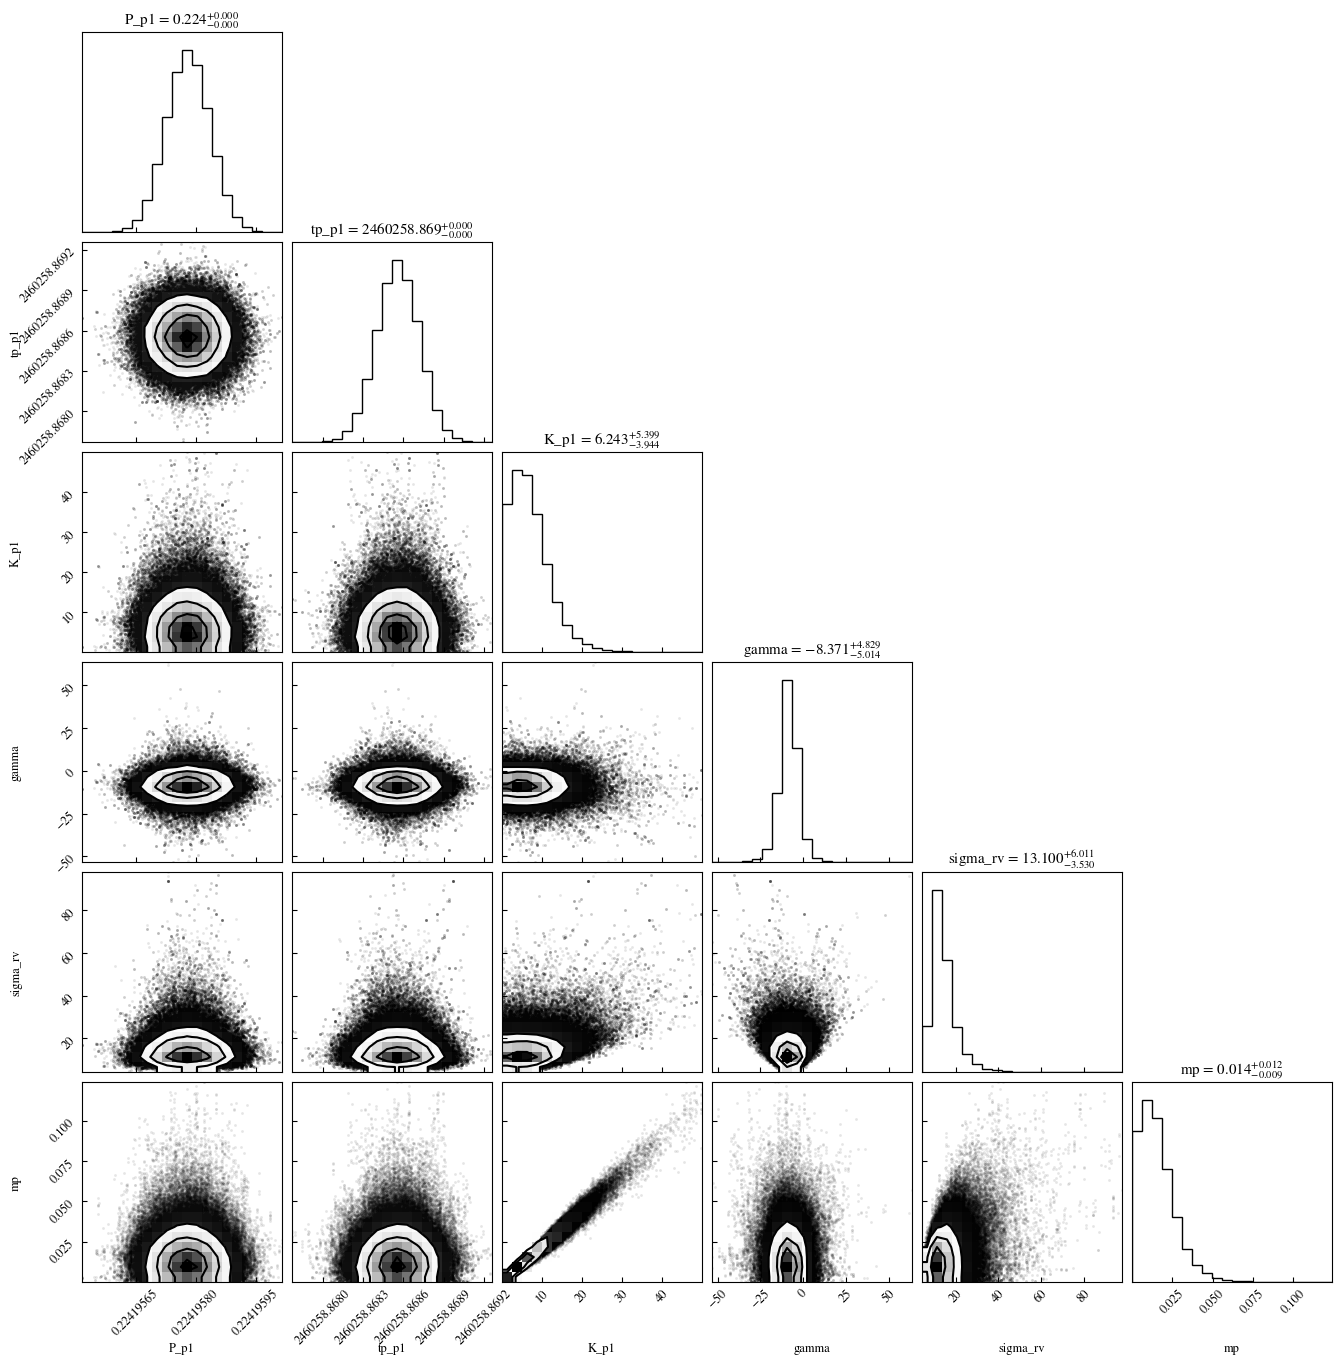

In [17]:
#We then plot the Corner Plot.
import corner
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

#We then need to access the figure axes in order to obtain the planet mass.
axes = fig.get_axes()

#Now we look for the planet mass using the titles of the corner plot.
mp_title = None
for ax in axes:
    title = ax.get_title() 
    if 'mp' in title:
        mp_title = title
        break

#We show the corner plot.
#plt.savefig("cornerplot_mass.png", dpi = 500)
plt.show();

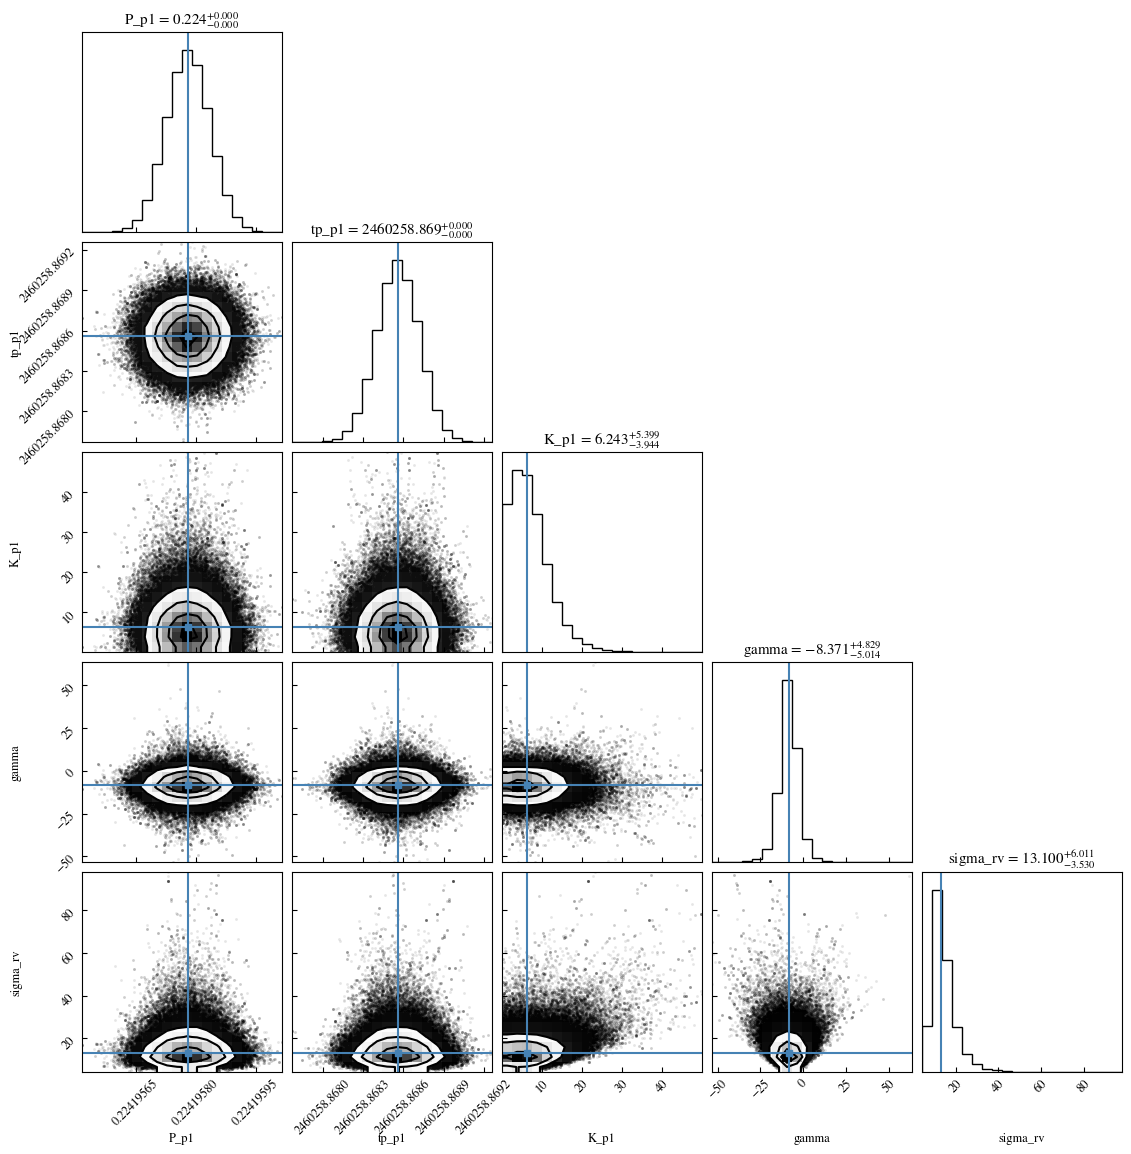

In [18]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.iloc[:, :-1].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :-1].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

#plt.savefig("cornerplot.png", dpi = 500)
plt.show();

In [19]:
#We get the Mass from the MCMC chains to convert it to Earth Mass values.
# obj = [df_medvals[df_medvals.Labels=='mp']['values'].values[0]]
obj = mp_title

#We then extract the numbers and remove the $ and {} characters
cleaned_str = obj.replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('mp = ', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value, lower_error, upper_error = cleaned_str.split('-')[0], cleaned_str.split('-')[1].split('+')[0], cleaned_str.split('+')[1]
lower_error = lower_error.replace('^', '')
upper_error = upper_error.replace('^', '')

#Now we convert all of them to floats and multiply them Earth Mass factor. (1 M_Jupiter = 317.83 M_Earth)
factor = 317.83
central_value = float(central_value) * factor
lower_error = float(lower_error) * factor
upper_error = float(upper_error) * factor

#We then format it back to the original string from the output.
mass_converted = f"${central_value:.3f}_{{-{lower_error:.3f}}}^{{+{upper_error:.3f}}}$"
print(mass_converted)

$4.450_{-2.860}^{+3.814}$


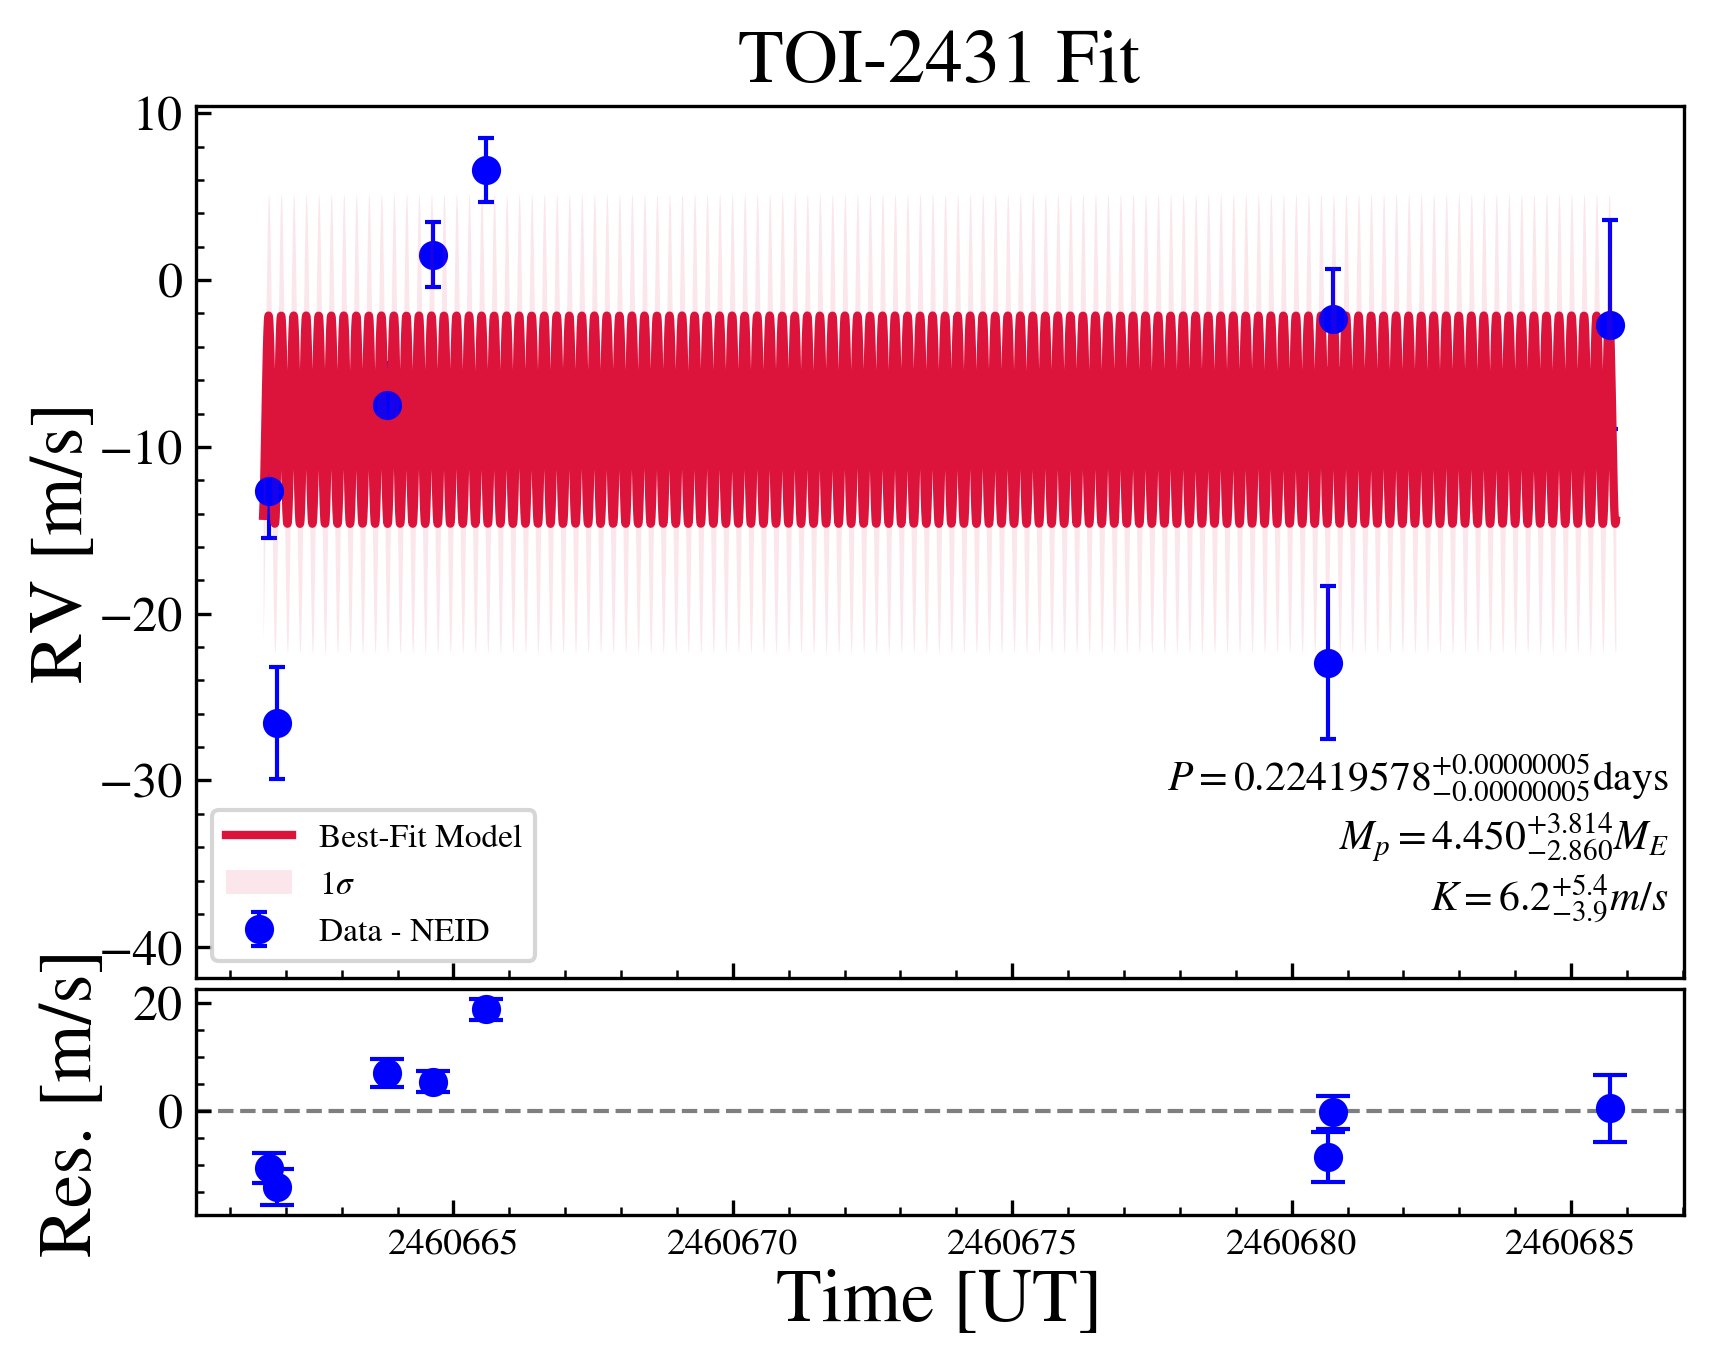

In [20]:
#We import astropy.time to convert Julian Dates into Datetimes i.e. the DD-MM-YYYY Format.
import astropy.time

#We define a function that turns Julian Dates into Datetime format.
def jd2datetime(times):
    return times
    #return np.array([astropy.time.Time(time,format="jd",scale="utc").datetime for time in times])

#We define the Title, Number of Models and the Shade color.
TITLE = 'TOI-2431 Fit'
NUMMODELS = 5000
shadecolor="black"

###################
#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data['x'][0]-0.05,TF.lpf.data['x'][-1]+0.05,500)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.05,times1.max()+0.05,5000)

#Our goal is to get the Residuals i.e. Data - Model.
#For that first we compute the Radial Velocities for both instruments using 50th percentiles i.e. the Model.
rv_501 = TF.lpf.compute_total_model(pv_50,t1_mod)

#Then we get the Radial Velocities for both instruments using the datafiles we have i.e. Data.
rv_50_obs1 = TF.lpf.compute_total_model(pv_50,TF.lpf.data['x'])

#We calculate the residuals.
res1 = TF.lpf.data['y'] - rv_50_obs1

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(dpi=300,nrows=2,gridspec_kw={'height_ratios': [5,1.3]},sharex=True)

#################
# Plot data
#################
#We first plot the Best-Fit Model.
#For that we first define a label.
label = r'Best-Fit Model'

#Then we also add the values of Period and Eccentricity into our label.
#Note that we are using "df_medvals" we found after MCMC.
#Note that we can also add Planet Mass and Inclination by removing "#" from the lines below.
lab = '$P=${}'.format(df_medvals[df_medvals.Labels=='P_p1']['values'].values[0])+'days\n'
lab += r'$M_p=${}$M_E$'.format(mass_converted)+'\n'
#lab += r'$e=${}'.format(df_medvals[df_medvals.Labels=='ecc_p1']['values'].values[0])+'\n'
lab += r'$K=${}$m/s$'.format(df_medvals[df_medvals.Labels=='K_p1']['values'].values[0])+'\n'

#We define the marker color to be black for errorbars.
markercolor="blue"

# uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]
uncertainty_sigma = 0
inflated_rv_err = np.sqrt(pow(TF.lpf.data['error'],2)+(pow(uncertainty_sigma,2)))

#We define the errorbars & datapoints.
#Note that we put times into the jd2datetime function so that the dates turn from JD to Datetime.
#ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],TF.lpf.data['error'],
            #marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color=markercolor,markersize=6,label='Data - HERMES')
ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],inflated_rv_err,
             marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color="blue",markersize=6,label='Data - NEID',
             zorder = -10)

#We finally also plot our model as follows.
ax.plot(jd2datetime(t1_mod),rv_501,color="crimson",label=label,lw=2.,zorder=-10)

#Now we work on the second Row for the Resiudal graph.
#We also need to plot the residuals with the error bars included.

#For that we define the errorbars & datapoints for the first dataset from first instrument.
# bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,TF.lpf.data['error'],
#             marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color=markercolor,markersize=6)
bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,inflated_rv_err,
             marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color="blue",markersize=6, zorder=-10)

#We add the values of our Parameters to the Bottom-Right of our first Graph i.e. RV Graph.
ax.text(0.99,0.01,lab,va='bottom',ha='right',fontsize=10,transform=ax.transAxes)

#We define a list to sample from our model, which we will use for Sigma Errors of our Fit.
mmodel1 = []
for i in range(NUMMODELS):
    #if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)

#We then show the 1-Sigma Error of our fit as follows.
#There are also options for 2-Sigma and 3-Sigma Errors, commented below.
ax.fill_between(jd2datetime(t1_mod),np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color='crimson',lw=0,label='1$\sigma$',zorder=-1)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-10, ylim[-1]+0)

#plt.savefig("toi_2431_result.png", dpi = 500)
plt.show();

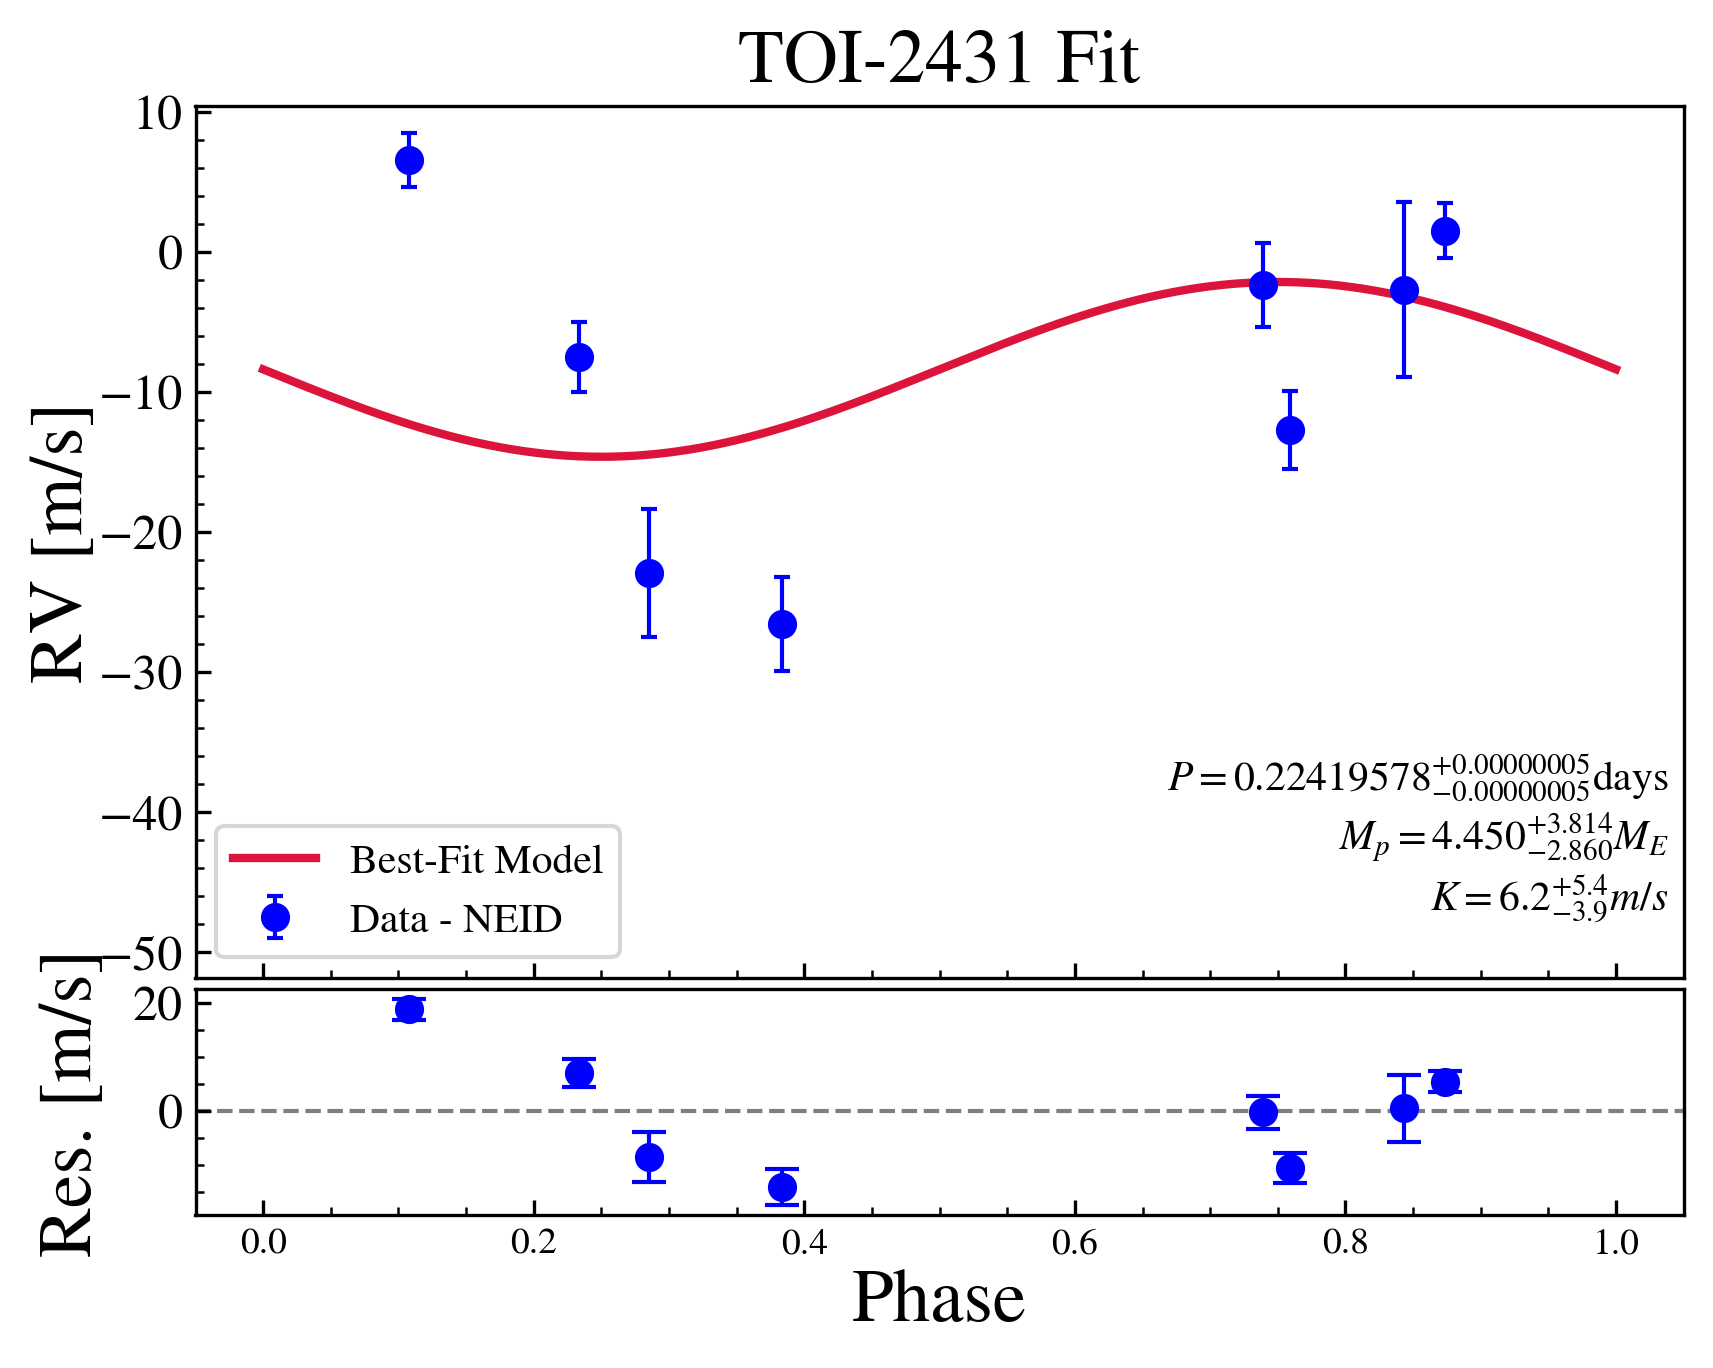

In [21]:
#We get the P and T0 values from the MCMC results.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "tp_p1"].values[0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0) % P) / P

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data['x'], P, T_0)

#We also convert the times for the model/fit to the orbital phases.
phase_model = time_to_phase(t1_mod, P, T_0)

#Now we define a figure again for our Phase Curve & Residuals.
fig, (ax, bx) = plt.subplots(dpi=300, nrows=2, gridspec_kw={'height_ratios': [5, 1.3]}, sharex=True)

#################
# Plot data
#################

#We first sort our data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_501_sorted = rv_501[sorted_indices]

#Then we plot the fit as follows.
label = r'Best-Fit Model'
ax.plot(phase_model_sorted, rv_501_sorted, color="crimson", label=label, lw=2., zorder=-10)

#We then plot our data around the fit as follows.
ax.errorbar(phase1, TF.lpf.data['y'], inflated_rv_err,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color=markercolor, markersize=6, label='Data - NEID')

#We plot the residuals on the second row as follows.
res1 = TF.lpf.data['y'] - rv_50_obs1
bx.errorbar(phase1, res1, inflated_rv_err,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color=markercolor, markersize=6)

#We add the label for the fit parameters
ax.text(0.99, 0.01, lab, va='bottom', ha='right', fontsize=10, transform=ax.transAxes)

# For plotting the sigma errors (1-sigma range) - Does not work.
# mmodel1 = []
# for i in range(NUMMODELS):
#     idx = np.random.randint(0, flatchain.shape[0])
#     m1 = TF.lpf.compute_total_model(flatchain[idx], times=t1_mod)
#     mmodel1.append(m1)
# mmodel1 = np.array(mmodel1)

# # Plot 1-sigma error range
# ax.fill_between(phase_model, np.quantile(mmodel1, 0.16, axis=0), np.quantile(mmodel1, 0.84, axis=0),
#                 alpha=0.1, color='crimson', lw=0, label='1$\sigma$', zorder=-1)

#We add the legend and the labels.
ax.legend(loc='lower left', fontsize=10)
ax.set_ylabel('RV [m/s]', labelpad=0, fontsize=18)
bx.set_xlabel('Phase', labelpad=2, fontsize=18)
bx.set_ylabel('Res. [m/s]', labelpad=6, fontsize=18)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=10)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-20, ylim[-1]+0)

#plt.savefig("toi_2431_result_phase.png", dpi = 500)
plt.show();

In [22]:
#Adding audio to know the fit has finished.
from IPython.display import Audio

beep = np.sin(2*np.pi*800*np.arange(3000*2)/100000)
Audio(beep, rate=100000, autoplay=True)

In [23]:
#Now we import all the planets that have a confirmed mass and radius.
planet_file = '../../data/toi2431_extra/PS_2024.12.07_03.23.11.csv'
planet_df = pd.read_csv(planet_file, comment = "#")

#We then get the Names, Masses and the Radii as follows.
planet_names = planet_df["pl_name"]

#Masses => [Earth Masses]
planet_masses = planet_df["pl_bmasse"]
planet_mass_err1 = planet_df["pl_bmasseerr1"]
planet_mass_err2 = planet_df["pl_bmasseerr2"]

#Radii => [Earth Radius]
planet_radii = planet_df["pl_rade"]
planet_radii_err1 = planet_df["pl_radeerr1"]
planet_radii_err2 = planet_df["pl_radeerr2"]

####################################################################################################################

#We also filter the planets with uncertainties that are larger than %33 of the median value in radius or mass out of
#our dataset.
#For this, we get the upper and lower errors first.
planet_mass_err1_abs = planet_mass_err1.abs()
planet_mass_err2_abs = planet_mass_err2.abs()
planet_radius_err1_abs = planet_radii_err1.abs()
planet_radius_err2_abs = planet_radii_err2.abs()

#For this, we first calculate the TOTAL uncertainties for each planet, which is the average of positive and negative
#errors.
# planet_mass_uncertainty = (planet_mass_err1.abs() + planet_mass_err2.abs()) / 2
# planet_radius_uncertainty = (planet_radii_err1.abs() + planet_radii_err2.abs()) / 2

#We then calculate the threshold for the planets.
#In our case it is %33 of the median value i.e. %33 of its own mass and/or radius.
mass_threshold = 0.33 * planet_masses
radius_threshold = 0.33 * planet_radii

#We then filter the planets according to our thresholds, where the uncertainties are within these thresholds.
filtered_planets_df = planet_df[(planet_mass_err1_abs <= mass_threshold) & 
                                (planet_mass_err2_abs <= mass_threshold) &
                                (planet_radius_err1_abs <= radius_threshold) & 
                                (planet_radius_err2_abs <= radius_threshold)]
# filtered_planets_df = planet_df[(planet_mass_uncertainty <= mass_threshold) & 
#                                 (planet_radius_uncertainty <= radius_threshold)]

#Using the filtered planet dataframe, we can get the filtered planets' mass and radius.
planet_names_filtered = filtered_planets_df["pl_name"]

#Masses => [Earth Masses]
planet_masses_filtered = filtered_planets_df["pl_bmasse"].reset_index(drop=True)
planet_mass_err1_filtered = filtered_planets_df["pl_bmasseerr1"].reset_index(drop=True)
planet_mass_err2_filtered = filtered_planets_df["pl_bmasseerr2"].reset_index(drop=True)

#Radii => [Earth Radius]
planet_radii_filtered = filtered_planets_df["pl_rade"].reset_index(drop=True)
planet_radii_err1_filtered = filtered_planets_df["pl_radeerr1"].reset_index(drop=True)
planet_radii_err2_filtered = filtered_planets_df["pl_radeerr2"].reset_index(drop=True)

#We count how many planet masses are greater than 10 Earth masses.
# count_above_10 = (mass_threshold > 10).sum()
# print(f"Number of planets with mass greater than 10 Earth masses: {count_above_10}")

In [24]:
#Now we plot the Mass vs Radius plot.
# fig = plt.figure(figsize = (10, 6))
# plt.errorbar(planet_masses, planet_radii, 
#              xerr = [np.abs(planet_mass_err2), planet_mass_err1], 
#              yerr = [np.abs(planet_radii_err2), planet_radii_err1], 
#              fmt = "o", color = "blue", ecolor = "red", capsize = 3, label = "Confirmed Exoplanets")
# plt.xlabel("Planet Masses [Earth Mass]")
# plt.ylabel("Planet Radii [Earth Radius]")
# plt.title("Exoplanet Population - Mass vs. Radius")
# plt.xscale("log")
# plt.legend()
# plt.show()

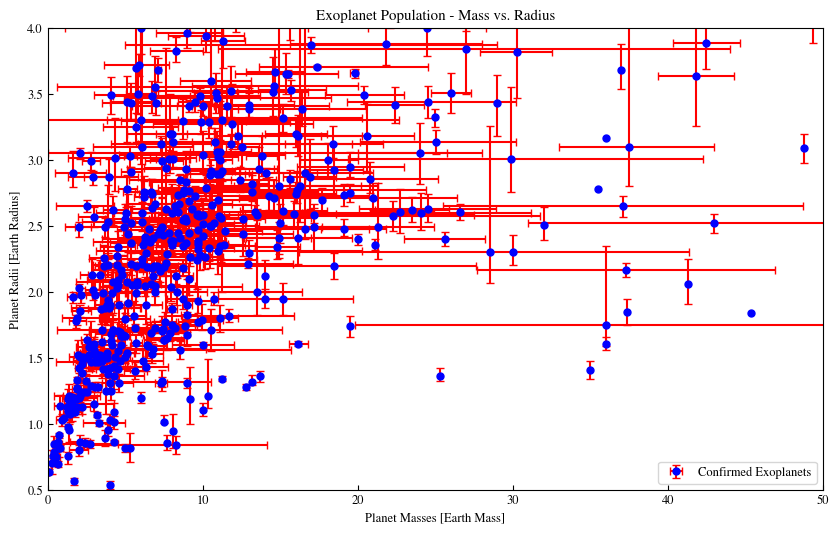

In [25]:
#Now we plot the Mass vs Radius plot, with limits.
fig = plt.figure(figsize = (10, 6))
plt.errorbar(planet_masses, planet_radii, 
             xerr = [np.abs(planet_mass_err2), planet_mass_err1], 
             yerr = [np.abs(planet_radii_err2), planet_radii_err1], 
             fmt = "o", color = "blue", ecolor = "red", capsize = 3, label = "Confirmed Exoplanets")
plt.xlabel("Planet Masses [Earth Mass]")
plt.ylabel("Planet Radii [Earth Radius]")
plt.title("Exoplanet Population - Mass vs. Radius")

#We setup the x and y limits.
plt.xlim(0,50)
plt.ylim(0.5,4.0)

plt.legend()
plt.show()

In [26]:
#Now we plot the Mass vs Radius plot, with limits.
# fig = plt.figure(figsize = (10, 6))
# plt.errorbar(planet_masses, planet_radii, 
#              xerr = [np.abs(planet_mass_err2), planet_mass_err1], 
#              yerr = [np.abs(planet_radii_err2), planet_radii_err1], 
#              fmt = "o", color = "blue", ecolor = "red", capsize = 3, label = "Confirmed Exoplanets")
# for i, name in enumerate(planet_names):
#     plt.text(planet_masses[i], planet_radii[i], name, fontsize=9, ha='right')
# plt.xlabel("Planet Masses [Earth Mass]")
# plt.ylabel("Planet Radii [Earth Radius]")
# plt.title("Exoplanet Population - Mass vs. Radius")

# #We setup the x and y limits.
# plt.xlim(0,50)
# plt.ylim(0.5,4.0)

# plt.legend()
# plt.show()

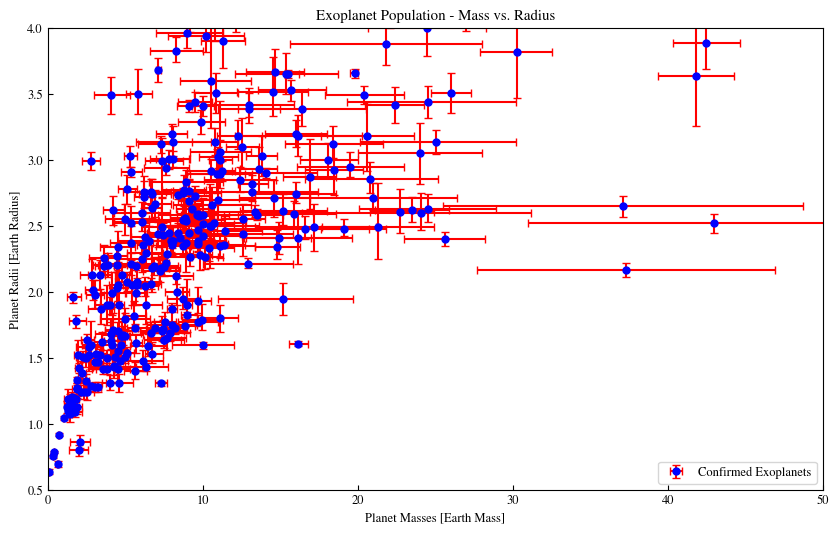

In [27]:
#Now we plot the Filtered Mass vs Radius plot, with limits.
fig = plt.figure(figsize = (10, 6))
plt.errorbar(planet_masses_filtered, planet_radii_filtered, 
             xerr = [np.abs(planet_mass_err2_filtered), planet_mass_err1_filtered], 
             yerr = [np.abs(planet_radii_err2_filtered), planet_radii_err1_filtered], 
             fmt = "o", color = "blue", ecolor = "red", capsize = 3, label = "Confirmed Exoplanets")
plt.xlabel("Planet Masses [Earth Mass]")
plt.ylabel("Planet Radii [Earth Radius]")
plt.title("Exoplanet Population - Mass vs. Radius")

#We setup the x and y limits.
plt.xlim(0,50)
plt.ylim(0.5,4.0)

plt.legend()
plt.show()

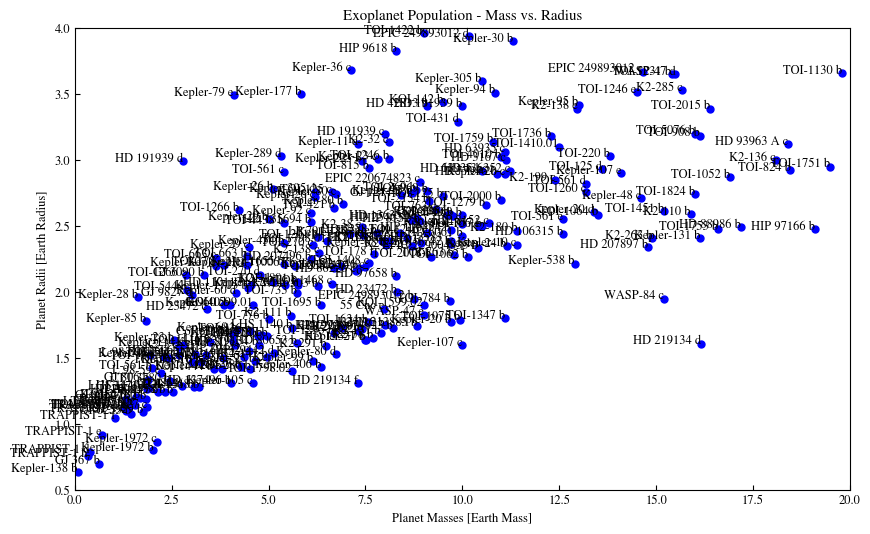

In [28]:
#Now we plot the Mass vs Radius plot, with limits.
fig = plt.figure(figsize = (10, 6))
plt.scatter(planet_masses_filtered, planet_radii_filtered, color='blue')
for i, name in enumerate(planet_names_filtered):
    if 0 <= planet_masses_filtered[i] <= 20 and 0.5 <= planet_radii_filtered[i] <= 4.0:
        plt.text(planet_masses_filtered[i], planet_radii_filtered[i], name, fontsize=9, ha='right')
plt.xlabel("Planet Masses [Earth Mass]")
plt.ylabel("Planet Radii [Earth Radius]")
plt.title("Exoplanet Population - Mass vs. Radius")

#We setup the x and y limits.
plt.xlim(0,20)
plt.ylim(0.5,4.0)

plt.show()

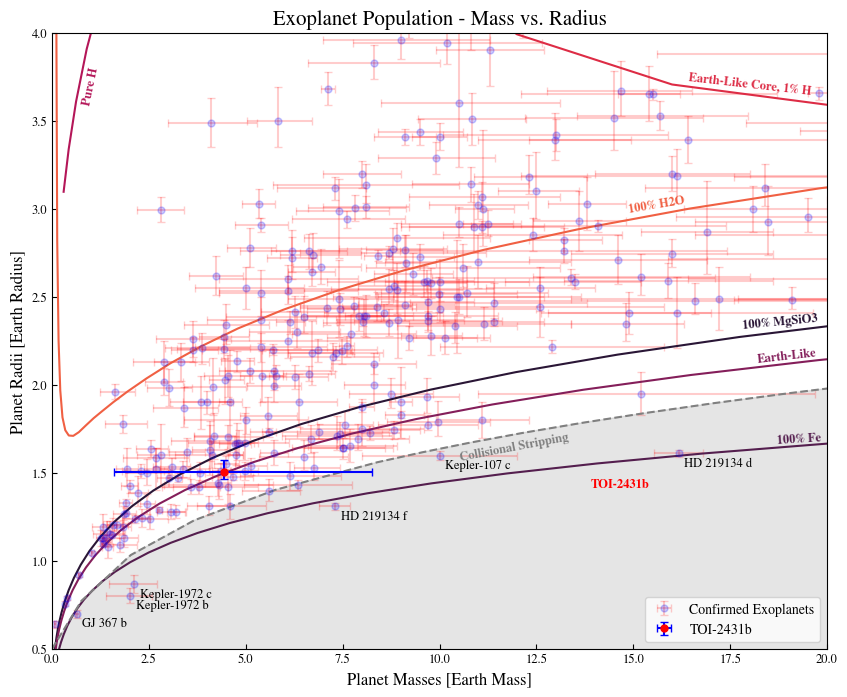

In [29]:
#We first define the colors we will use.
import seaborn as sns

colors = sns.color_palette("rocket", 8)

#Now we can add the Density Curves to our plot. (https://lweb.cfa.harvard.edu/~lzeng/planetmodels.html#mrtables)
#For this, we import the txt files that have the density curves.
mgsio_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusmgsio3.txt')
fe_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusFe.txt')
rocky_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusEarthlikeRocky.txt')
max_col_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusMaxCollisionStripping.txt')
pure_hydrogen = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiushydrogen.txt')

earth_like_one_h = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike1h2000K1mbar.txt')
all_h2o = np.loadtxt('../../data/toi2431_extra/Density Tables/massradius_100percentH2O_1000K_1mbar.txt')
earth_like_five_h2 = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike5h2000K1mbar.txt')

#Now we plot the Mass vs Radius plot with curves.
fig = plt.figure(figsize = (10, 8))

#We setup the x and y limits.
plt.xlim(0,20)
plt.ylim(0.5,4.0)

#We plot the known exoplanets.
#Note that since the err2 errors are negative (lower errors), we need to make them positive hence the np.abs.
plt.errorbar(planet_masses_filtered, planet_radii_filtered, 
             xerr = [np.abs(planet_mass_err2_filtered), planet_mass_err1_filtered], 
             yerr = [np.abs(planet_radii_err2_filtered), planet_radii_err1_filtered], 
             fmt = "o", color = "blue", ecolor = "red", alpha = 0.2, capsize = 3, label = "Confirmed Exoplanets")

#We plot the Mass-Radius Curves.
plt.plot(mgsio_curve[:, 0], mgsio_curve[:, 1], color = colors[0])
plt.text(17.8, 2.32, "100% MgSiO3", color = colors[0], rotation = 5.5, weight = "bold")

plt.plot(fe_curve[:, 0], fe_curve[:, 1], color = colors[1])
plt.text(18.7, 1.67, "100% Fe", color = colors[1], rotation = 3.5, weight = "bold")

plt.plot(rocky_curve[:, 0], rocky_curve[:, 1], color = colors[2])
plt.text(18.2, 2.13, "Earth-Like", color = colors[2], rotation = 6.5, weight = "bold")

plt.plot(max_col_curve[:, 0], max_col_curve[:, 1], "--", color = "grey")
plt.text(10.5, 1.57, "Collisional Stripping", color = "grey", rotation = 10.75, weight = "bold")
plt.fill_between(max_col_curve[:, 0], 0, max_col_curve[:, 1], color = "gray", alpha = 0.2)

plt.plot(pure_hydrogen[:, 0], pure_hydrogen[:, 1], color = colors[3])
plt.text(0.75, 3.6, "Pure H", color = colors[3], rotation = 78.25, weight = "bold")

plt.plot(earth_like_one_h[:, 0], earth_like_one_h[:, 1], color = colors[4])
plt.text(16.4, 3.65, "Earth-Like Core, 1% H", color = colors[4], rotation = -6.5, weight = "bold")

plt.plot(all_h2o[:, 0], all_h2o[:, 1], color = colors[5])
plt.text(14.85, 2.98, "100% H2O", color = colors[5], rotation = 9.5, weight = "bold")

plt.plot(earth_like_five_h2[:, 0], earth_like_five_h2[:, 1], color = colors[6])
#plt.text(35.5, 5.35, "Earth-Like Core, 5% H2", color = colors[6], rotation = -4, weight = "bold")

#We then plot our Planet, TOI-2431b.
#Note that we take the mass values from the analysis we have done in one of the cells above when converting from
#Jupiter Radius to Earth Radius.
#Radius Value taken from ExoFop!
plt.errorbar(central_value, 1.507337878105491, xerr = [[lower_error], [upper_error]], 
             yerr = [[0.04082678180277368],[0.06388331694386264]], fmt = "o", 
             color = "red", ecolor = "blue", capsize = 3, label = "TOI-2431b")
plt.text(13.90, 1.42, "TOI-2431b", color = "red", weight = "bold")

#We also add labels to similar planets to our target that have been well-studied before.
for i, name in enumerate(planet_names_filtered):
    if 0 <= planet_masses_filtered[i] <= 20 and 0.5 <= planet_radii_filtered[i] <= 4.0:
        if (name == "Kepler-107 c" or name == "HD 219134 f" or name == "HD 219134 d" or name == "Kepler-1972 c" or name == "Kepler-1972 b"
        or name == "GJ 367 b"):
            plt.text(planet_masses_filtered[i]+0.15, planet_radii_filtered[i]-0.09, name, fontsize=9, ha='left', va='bottom')
        
plt.xlabel("Planet Masses [Earth Mass]", fontsize = 12)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 12)
plt.title("Exoplanet Population - Mass vs. Radius", fontsize = 15)

plt.legend(fontsize = 10)
#plt.savefig("toi_2431_massvsradius.png", dpi = 500)
plt.show()

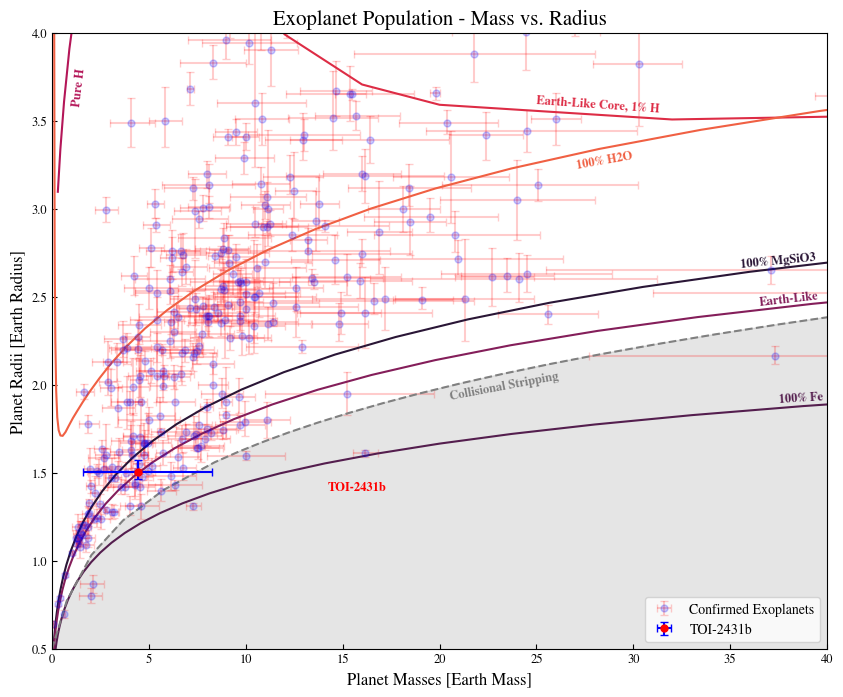

In [30]:
#We first define the colors we will use.
import seaborn as sns

colors = sns.color_palette("rocket", 8)

#Now we can add the Density Curves to our plot. (https://lweb.cfa.harvard.edu/~lzeng/planetmodels.html#mrtables)
#For this, we import the txt files that have the density curves.
mgsio_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusmgsio3.txt')
fe_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusFe.txt')
rocky_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusEarthlikeRocky.txt')
max_col_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusMaxCollisionStripping.txt')
pure_hydrogen = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiushydrogen.txt')

earth_like_one_h = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike1h2000K1mbar.txt')
all_h2o = np.loadtxt('../../data/toi2431_extra/Density Tables/massradius_100percentH2O_1000K_1mbar.txt')
earth_like_five_h2 = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike5h2000K1mbar.txt')

#Now we plot the Mass vs Radius plot with curves.
fig = plt.figure(figsize = (10, 8))

#We setup the x and y limits.
plt.xlim(0,40)
plt.ylim(0.5,4.0)

#We plot the known exoplanets.
#Note that since the err2 errors are negative (lower errors), we need to make them positive hence the np.abs.
plt.errorbar(planet_masses_filtered, planet_radii_filtered, 
             xerr = [np.abs(planet_mass_err2_filtered), planet_mass_err1_filtered], 
             yerr = [np.abs(planet_radii_err2_filtered), planet_radii_err1_filtered], 
             fmt = "o", color = "blue", ecolor = "red", alpha = 0.2, capsize = 3, label = "Confirmed Exoplanets")

#We plot the Mass-Radius Curves.
plt.plot(mgsio_curve[:, 0], mgsio_curve[:, 1], color = colors[0])
plt.text(35.5, 2.67, "100% MgSiO3", color = colors[0], rotation = 5.5, weight = "bold")

plt.plot(fe_curve[:, 0], fe_curve[:, 1], color = colors[1])
plt.text(37.5, 1.9, "100% Fe", color = colors[1], rotation = 3.5, weight = "bold")

plt.plot(rocky_curve[:, 0], rocky_curve[:, 1], color = colors[2])
plt.text(36.5, 2.45, "Earth-Like", color = colors[2], rotation = 6.5, weight = "bold")

plt.plot(max_col_curve[:, 0], max_col_curve[:, 1], "--", color = "grey")
plt.text(20.5, 1.92, "Collisional Stripping", color = "grey", rotation = 10.75, weight = "bold")
plt.fill_between(max_col_curve[:, 0], 0, max_col_curve[:, 1], color = "gray", alpha = 0.2)

plt.plot(pure_hydrogen[:, 0], pure_hydrogen[:, 1], color = colors[3])
plt.text(1.0, 3.6, "Pure H", color = colors[3], rotation = 83.25, weight = "bold")

plt.plot(earth_like_one_h[:, 0], earth_like_one_h[:, 1], color = colors[4])
plt.text(25, 3.55, "Earth-Like Core, 1% H", color = colors[4], rotation = -4, weight = "bold")

plt.plot(all_h2o[:, 0], all_h2o[:, 1], color = colors[5])
plt.text(27, 3.23, "100% H2O", color = colors[5], rotation = 10, weight = "bold")

plt.plot(earth_like_five_h2[:, 0], earth_like_five_h2[:, 1], color = colors[6])
#plt.text(35.5, 5.35, "Earth-Like Core, 5% H2", color = colors[6], rotation = -4, weight = "bold")

#We then plot our Planet, TOI-2431b.
#Note that we take the mass values from the analysis we have done in one of the cells above when converting from
#Jupiter Radius to Earth Radius.
#Radius Value taken from ExoFop!
plt.errorbar(central_value, 1.507337878105491, xerr = [[lower_error], [upper_error]], 
             yerr = [[0.04082678180277368],[0.06388331694386264]], fmt = "o", 
             color = "red", ecolor = "blue", capsize = 3, label = "TOI-2431b")
plt.text(14.2, 1.40, "TOI-2431b", color = "red", weight = "bold")

plt.xlabel("Planet Masses [Earth Mass]", fontsize = 12)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 12)
plt.title("Exoplanet Population - Mass vs. Radius", fontsize = 15)

plt.legend(fontsize = 10)
#plt.savefig("toi_2431_massvsradius.png", dpi = 500)
plt.show()

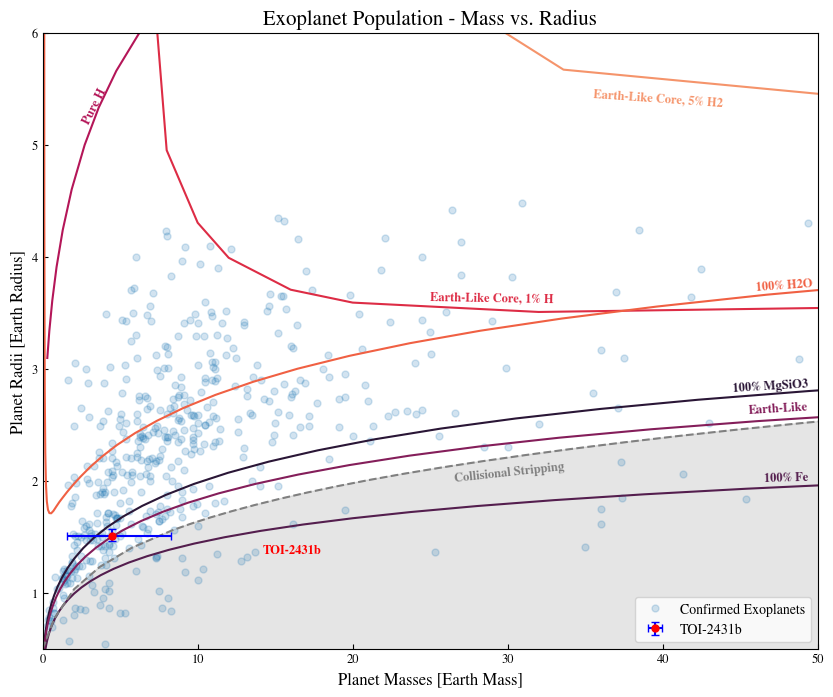

In [31]:
#We first define the colors we will use.
import seaborn as sns

colors = sns.color_palette("rocket", 8)

#Now we can add the Density Curves to our plot. (https://lweb.cfa.harvard.edu/~lzeng/planetmodels.html#mrtables)
#For this, we import the txt files that have the density curves.
mgsio_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusmgsio3.txt')
fe_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusFe.txt')
rocky_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusEarthlikeRocky.txt')
max_col_curve = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiusMaxCollisionStripping.txt')
pure_hydrogen = np.loadtxt('../../data/toi2431_extra/Density Tables/massradiushydrogen.txt')

earth_like_one_h = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike1h2000K1mbar.txt')
all_h2o = np.loadtxt('../../data/toi2431_extra/Density Tables/massradius_100percentH2O_1000K_1mbar.txt')
earth_like_five_h2 = np.loadtxt('../../data/toi2431_extra/Density Tables/Earthlike5h2000K1mbar.txt')

#Now we plot the Mass vs Radius plot with curves.
fig = plt.figure(figsize = (10, 8))

#We setup the x and y limits.
plt.xlim(0,50)
plt.ylim(0.5,6.0)

#We plot the known exoplanets.
plt.plot(planet_masses, planet_radii, "o", alpha = 0.2, label = "Confirmed Exoplanets")

#We plot the Mass-Radius Curves.
plt.plot(mgsio_curve[:, 0], mgsio_curve[:, 1], color = colors[0])
plt.text(44.5, 2.8, "100% MgSiO3", color = colors[0], rotation = 3.5, weight = "bold")

plt.plot(fe_curve[:, 0], fe_curve[:, 1], color = colors[1])
plt.text(46.5, 2.0, "100% Fe", color = colors[1], rotation = 1.5, weight = "bold")

plt.plot(rocky_curve[:, 0], rocky_curve[:, 1], color = colors[2])
plt.text(45.5, 2.6, "Earth-Like", color = colors[2], rotation = 3.5, weight = "bold")

plt.plot(max_col_curve[:, 0], max_col_curve[:, 1], "--", color = "grey")
plt.text(26.5, 2.0, "Collisional Stripping", color = "grey", rotation = 6.25, weight = "bold")
plt.fill_between(max_col_curve[:, 0], 0, max_col_curve[:, 1], color = "gray", alpha = 0.2)

plt.plot(pure_hydrogen[:, 0], pure_hydrogen[:, 1], color = colors[3])
plt.text(2.5, 5.2, "Pure H", color = colors[3], rotation = 63.25, weight = "bold")

plt.plot(earth_like_one_h[:, 0], earth_like_one_h[:, 1], color = colors[4])
plt.text(25, 3.6, "Earth-Like Core, 1% H", color = colors[4], rotation = -1, weight = "bold")

plt.plot(all_h2o[:, 0], all_h2o[:, 1], color = colors[5])
plt.text(46, 3.70, "100% H2O", color = colors[5], rotation = 4, weight = "bold")

plt.plot(earth_like_five_h2[:, 0], earth_like_five_h2[:, 1], color = colors[6])
plt.text(35.5, 5.35, "Earth-Like Core, 5% H2", color = colors[6], rotation = -4, weight = "bold")

#We then plot our Planet, TOI-2431b.
#Note that we take the mass values from the analysis we have done in one of the cells above when converting from
#Jupiter Radius to Earth Radius.
#Radius Value taken from ExoFop!
plt.errorbar(central_value, 1.507337878105491, xerr = [[lower_error], [upper_error]], 
             yerr = [[0.04082678180277368],[0.06388331694386264]], fmt = "o", 
             color = "red", ecolor = "blue", capsize = 3, label = "TOI-2431b")
plt.text(14.2, 1.35, "TOI-2431b", color = "red", weight = "bold")

plt.xlabel("Planet Masses [Earth Mass]", fontsize = 12)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 12)
plt.title("Exoplanet Population - Mass vs. Radius", fontsize = 15)

plt.legend(fontsize = 10)
#plt.savefig("toi_2431_massvsradius.png", dpi = 500)
plt.show()

In [32]:
#Now we check all of the discovered exoplanets (so far) and our planet's location on it.
#This is called the Exoplanet Population plot.
#First, we get the list of the planets.
planetpop_file = '../../data/toi2431_extra/PS_2024.12.07_05.41.49.csv'
planetpop_df = pd.read_csv(planetpop_file, comment = "#")

#We then get the Names, Masses and the Radii as follows.
planetpop_names = planetpop_df["pl_name"]

#Orbital Period => [days]
planetpop_periods = planetpop_df["pl_orbper"]

#Radii => [Earth Radius]
planetpop_radii = planetpop_df["pl_rade"]

#We also need to get the Period of TOI-2431b by using the MCMC results.
#For that, we first get the Posterior of the Period.
period_value = df_medvals.loc[df_medvals['Labels'] == 'P_p1', 'values'].values[0]

#We then extract the numbers and remove the $ and {} characters
cleaned_str = period_value.replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('mp = ', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value_per, lower_error_per, upper_error_per = cleaned_str.split('-')[0], cleaned_str.split('-')[1].split('+')[0], cleaned_str.split('+')[1]
lower_error_per = lower_error_per.replace('^', '')
upper_error_per = upper_error_per.replace('^', '')

#We turn the strings into floats.
central_value_per = float(central_value_per)
lower_error_per = float(lower_error_per)
upper_error_per = float(upper_error_per)

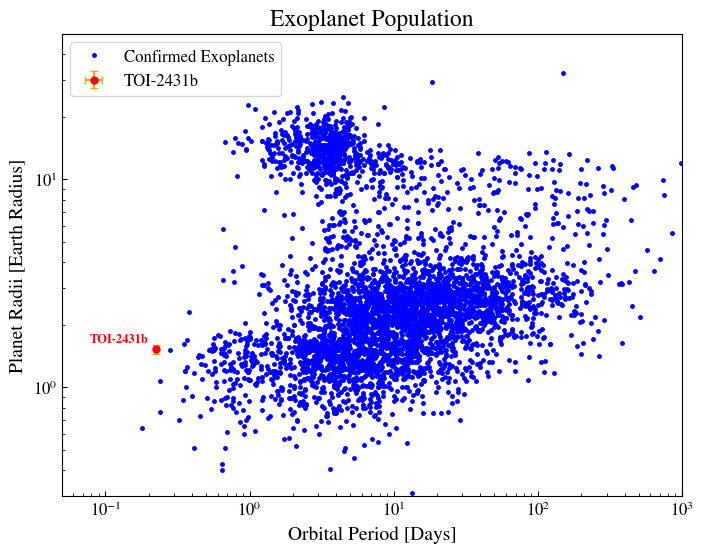

In [33]:
#Now we can plot the Exoplanet Population with our planet TOI-2431b. (Normal figsize = (10, 6))
fig = plt.figure(figsize = (8, 6))

#First we plot the Confirmed Exoplanets.
plt.plot(planetpop_periods, planetpop_radii, ".", color = "blue", label = "Confirmed Exoplanets")

#Then, we plot our planet TOI-2431b.
plt.errorbar(central_value_per, 1.5288416471212636, xerr = [[lower_error_per], [upper_error_per]], yerr = 0.07360631906382757, fmt = "o", 
             color = "red", ecolor = "orange", capsize = 3, label = "TOI-2431b")
plt.text(0.078, 1.65, "TOI-2431b", color = "red", weight = "bold", fontsize = 9)

plt.xlabel("Orbital Period [Days]", fontsize = 14)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 14)
plt.title("Exoplanet Population", fontsize = 17)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = "x", which = "major", labelsize = 12)
plt.tick_params(axis = "y", which = "major", labelsize = 12)

#Note: We are putting limit to the periods to see the Hot Neptune Desert clearer.
plt.xlim(0.05, 1000)
plt.ylim(0.3, 50)
plt.legend(loc = "upper left", fontsize = 12)
#plt.savefig("toi_2431_exopopulation.png", dpi = 500)
plt.show()

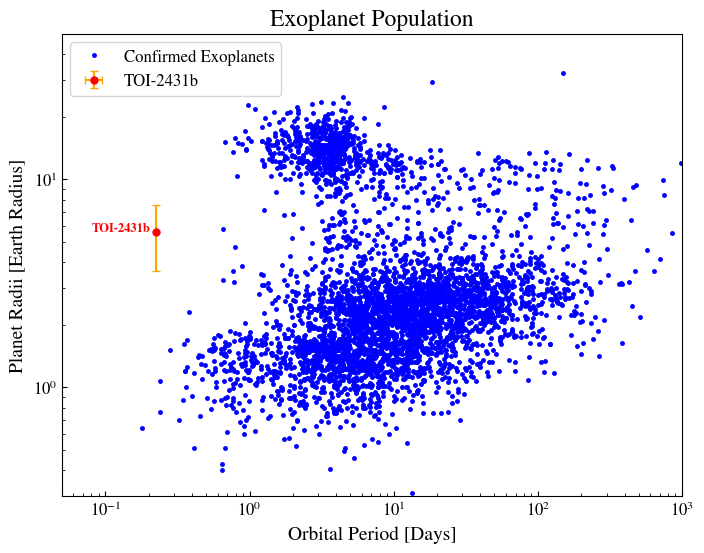

In [34]:
#Now we can plot the Exoplanet Population with our planet TOI-2431b. => Old Radius, from ExoFOP (wrong value).
fig = plt.figure(figsize = (8, 6))

#First we plot the Confirmed Exoplanets.
plt.plot(planetpop_periods, planetpop_radii, ".", color = "blue", label = "Confirmed Exoplanets")

#Then, we plot our planet TOI-2431b.
plt.errorbar(central_value_per, 5.59553, xerr = [[lower_error_per], [upper_error_per]], yerr = 1.95546, fmt = "o", 
             color = "red", ecolor = "orange", capsize = 3, label = "TOI-2431b")
plt.text(0.080, 5.65, "TOI-2431b", color = "red", weight = "bold", fontsize = 9)

plt.xlabel("Orbital Period [Days]", fontsize = 14)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 14)
plt.title("Exoplanet Population", fontsize = 17)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = "x", which = "major", labelsize = 12)
plt.tick_params(axis = "y", which = "major", labelsize = 12)

#Note: We are putting limit to the periods to see the Hot Neptune Desert clearer.
plt.xlim(0.05, 1000)
plt.ylim(0.3, 50)
plt.legend(loc = "upper left", fontsize = 12)
#plt.savefig("old_toi_2431_exopopulation.png", dpi = 500)
plt.show()

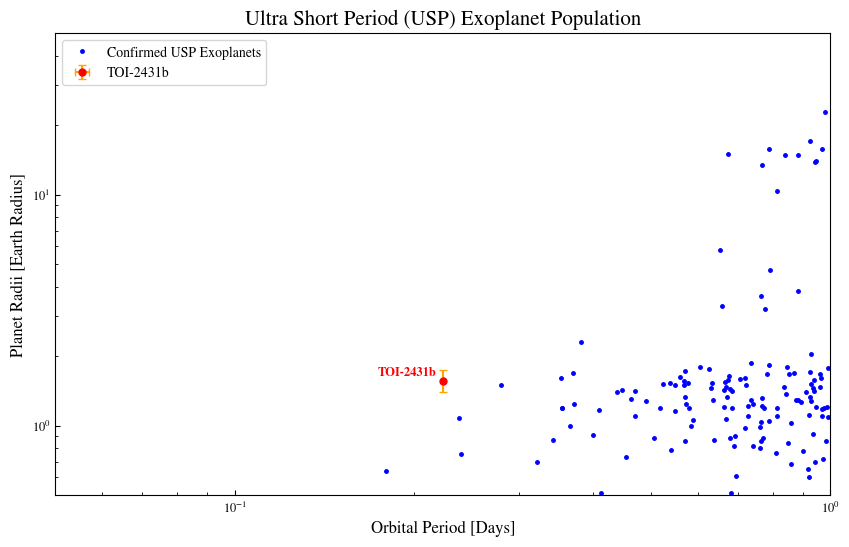

In [35]:
#We now check only the Ultra Short Period (USP) Planets to see whether our planet is the most massive USP.
planetpop_usp = planetpop_df[planetpop_df["pl_orbper"].values < 1]
fig = plt.figure(figsize = (10, 6))

#Now we plot all of the USP planets with our Planet.
plt.plot(planetpop_usp["pl_orbper"].values, planetpop_usp["pl_rade"].values, ".", color = "blue", 
         label = "Confirmed USP Exoplanets")

#Then, we plot our planet TOI-2431b.
plt.errorbar(central_value_per, 1.5682806577450292, xerr = [[lower_error_per], [upper_error_per]], yerr = 0.17, fmt = "o", 
             color = "red", ecolor = "orange", capsize = 3, label = "TOI-2431b")
plt.text(0.174, 1.65, "TOI-2431b", color = "red", weight = "bold")

plt.xlabel("Orbital Period [Days]", fontsize = 12)
plt.ylabel("Planet Radii [Earth Radius]", fontsize = 12)
plt.title("Ultra Short Period (USP) Exoplanet Population", fontsize = 15)
plt.xscale("log")
plt.yscale("log")

#Note: We are putting limit to the periods to see the Hot Neptune Desert clearer.
plt.xlim(0.05, 1)
plt.ylim(0.5, 50)
plt.legend(loc = "upper left", fontsize = 10)
#plt.savefig("toi_2431_USPexopopulation.png", dpi = 500)
plt.show()

In [36]:
#We get the Semi-Amplitude from the Chains.
obj_p = df_medvals[df_medvals.Labels=='K_p1']['values'].values[0]

#We then extract the numbers and remove the $ and {} characters
cleaned_str_p = obj.replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('K_p1 = ', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value_p, lower_error_p, upper_error_p = cleaned_str_p.split('-')[0], cleaned_str_p.split('-')[1].split('+')[0], cleaned_str_p.split('+')[1]
lower_error_p = lower_error_p.replace('^', '')
upper_error_p = upper_error_p.replace('^', '')

#We convert the strings to floats to obtain the results.
central_value_p, lower_error_p, upper_error_p = float(central_value_p), float(lower_error_p), float(upper_error_p)

central_value_p, lower_error_p, upper_error_p

ValueError: could not convert string to float: 'mp = 0.014'